In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from peel_by_motif import *
import random, collections
from datetime import datetime
import pandas as pd
import itertools, os
from utils import *
import math

plt.rcParams.update({'font.size': 14})

In [11]:
def kl_divergence(p, q):
    return sum(p[i] * math.log(p[i]/q[i]) for i in range(len(p)) if p[i]>0)

def node_chisquare(edgelist, node_num, dist, adjust_idx=1, directed='both', diff_func='chi'):
    '''
    edgelist: list of edges. Each item is a tuple contains (node_from, node_to, edge_weight) representing a weighted edge.
    node_num: number of nodes.
    dist: list of float sum to 1, describe the distribution used to calculate the chi square statistic. 
    '''
    node_induced_dist = [[] for i in range(node_num)]
    node_chis = []
    for edge in edgelist:
        if directed=='both' or directed=='out':
            node_induced_dist[edge[0]].append(edge[2])
        if directed=='both' or directed=='in':
            node_induced_dist[edge[1]].append(edge[2])
#             G[node][neighbor]['weight']
    for node_dist in node_induced_dist:
        count_dist = count_occ(node_dist, len(dist), adjust_idx)
#        get the chi square statistic, the higher it is, more abnormal the node is
        if diff_func=='chi':
            node_chis.append(chisquare(count_dist, sum(count_dist)*np.array(dist))[0])
        elif diff_func=='kl':
            node_chis.append(kl_divergence(np.array(count_dist)/sum(count_dist), np.array(dist)))
    return node_chis

## Preprocessing steps. Note the nx.Graph is constructed only for further graph analysis but not required for computing $\chi^2$.

In [3]:


benford = []
xs = [i for i in range(1,10)]
for i in range(9):
    benford.append(math.log10(1+1/(i+1)))

In [4]:
G = nx.DiGraph()
f = open('eth_token_jan2018.csv', 'r')
edgelist = []
node_map = {}
line = f.readline()
line = f.readline()
e_count = 0
n_idx = 0
while line:
    tmp = line.split(',')
    line = f.readline()
    date = tmp[-2].strip()
    money = tmp[-1].strip()
    if len(money)<=18:
        continue
    if tmp[1]==tmp[2]:
        continue
    if tmp[1] not in node_map:
        node_map[tmp[1]] = n_idx
        n_idx += 1
    if tmp[2] not in node_map:
        node_map[tmp[2]] = n_idx
        n_idx += 1
    money = int(money[:-18])
    edgelist.append((node_map[tmp[1]],node_map[tmp[2]],get_start_digit(money), money, date))

    if node_map[tmp[1]] in G and node_map[tmp[2]] in G[node_map[tmp[1]]]:
        G[node_map[tmp[1]]][node_map[tmp[2]]]['weight'].append(money) 
    else:
        G.add_edge(node_map[tmp[1]], node_map[tmp[2]], weight=[money])
#     amount_list.append(float(money))
    e_count += 1
    
#     break
print('amount of transactions with >1 volume', e_count, 'by', date)

amount of transactions with >1 volume 4279799 by 2018-01-31


In [106]:
G.number_of_nodes(), G.number_of_edges(), e_count/G.number_of_nodes()

(1761571, 2703193, 2.4295353408974147)

## empirical distribution and how it fits Benford distribution.

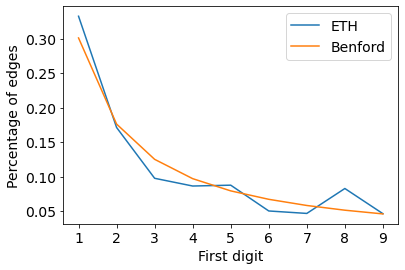

In [5]:
x = [e[2] for e in edgelist]
x = collections.Counter(x)
num_occ = np.array([x[k] for k in range(1,10)])/sum([x[k] for k in range(1,10)])
plt.plot([str(i) for i in range(1,10)], num_occ, label='ETH')
plt.plot([str(i) for i in range(1,10)], benford, label='Benford')
plt.xlabel('First digit')
plt.ylabel('Percentage of edges')
plt.legend()
# plt.tight_layout()
# plt.savefig('eth_results/figs/benford.png')
# plt.savefig(f_path + 'distribution_compare.eps', format='eps')
# plt.savefig(f_path + 'distribution_compare.pdf')
plt.show()

In [8]:
from scipy import stats
obs = [x[k] for k in range(1,10)]
times = sum(obs)
c3,p3 = stats.chisquare(obs, np.array(benford)*times)
c3, c3/G.number_of_nodes(), c3/G.number_of_edges()

(160315.89284999066, 0.09100734108928375, 0.05930612163097147)

## Compute $s(u)$

In [13]:
import time
start = time.time()
node_chisquares = node_chisquare(edgelist, G.number_of_nodes(), num_occ, adjust_idx=1, diff_func='kl')
print(time.time() - start)

23.67269778251648


## Histogram of Averaged $s(u)$ of the whole graph roughly fits the power law.

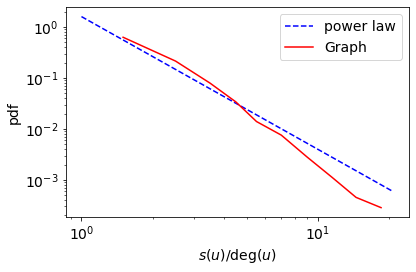

alpha=  2.6067687100645633   sigma=  0.004567910796801495


In [173]:
import powerlaw
for theta in [5]:
    avg_chi = []
    for i in range(G.number_of_nodes()):
        tmp_deg = sum([len(G[i][j]['weight']) for j in G[i]])
        if tmp_deg<theta:
            continue
        avg_chi.append(node_chisquares[i]/tmp_deg)

avg_chi = np.array(avg_chi)

fit = powerlaw.Fit(avg_chi[avg_chi>1],xmin=1,discrete=False)
fit.power_law.plot_pdf( color= 'b',linestyle='--',label='power law')
fit.plot_pdf( color= 'r',label='Graph')
plt.xlabel(r'$s(u)/\deg (u)$')
plt.ylabel('pdf')
plt.legend()
plt.tight_layout()
plt.savefig('eth_results/figs/eth18_pdf_powerlaw.png')
plt.show()
print('alpha= ',fit.power_law.alpha,'  sigma= ',fit.power_law.sigma)

## Converting the graph to weighted undirected version for DSD.

In [7]:

uG = G.to_undirected()
uG.remove_edges_from(nx.selfloop_edges(uG))
uG.number_of_nodes(), uG.number_of_edges()

(1761571, 2703193)

In [15]:
f_out = open('eth_weighted_sqrt.edgelist','w')
s = 0
f_out.write(str(uG.number_of_nodes())+' '+str(uG.number_of_edges())+'\n')
for edge in uG.edges():
    f_out.write(str(edge[0])+' '+str(edge[1])+' '+str(int(100*math.sqrt(node_chisquares[edge[0]]*node_chisquares[edge[1]])))+'\n')
f_out.close()

## Please run the C++ code in DSD_cpp folder to find top 5 dense(AntiBenford) subgraphs before running the following cells.

## Result analysis (top 5 Antibenford subgraph)

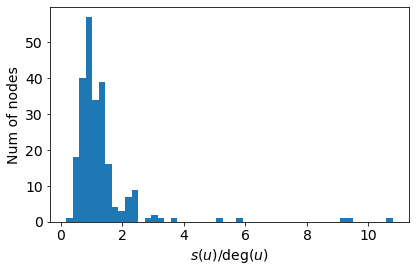

3429.123192934967 0.0 3622.8216021766625 0.0 14.408080642583897 18.76050420168067


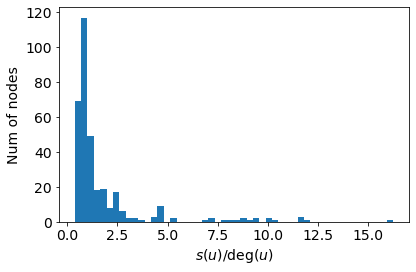

2587.634358650405 0.0 3080.621773622134 0.0 7.588370553226994 13.093841642228739


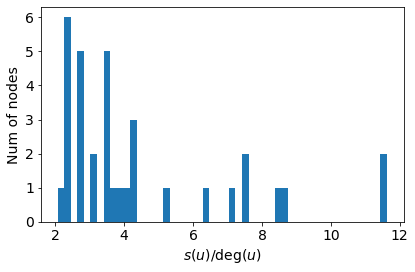

378.6532182674406 0.0 242.02562939360706 0.0 11.136859360807074 3.823529411764706


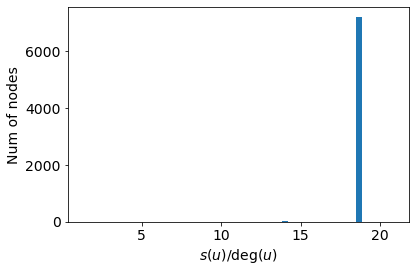

259047.91703195902 0.0 82685.76292465263 0.0 35.75540607756508 1.9625948930296757


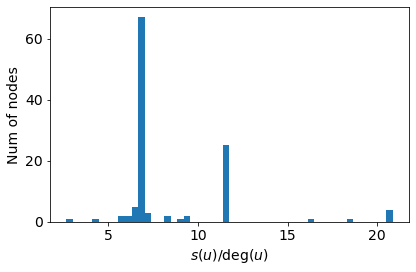

697.686384881766 0.0 532.2833217519863 0.0 5.96313149471595 1.9914529914529915


In [156]:
# check statistical significance
from scipy import stats

dsd_output_prefix = 'DSD_cpp/eth_sqrt.txt'

for idx in range(5):
    f = open(dsd_output_prefix+str(idx),'r')
    line = f.readline()
    res = []
    while line:
        res.append(int(line.strip()))
        line = f.readline()

    interest = G.subgraph(res)
    t = nx.get_edge_attributes(interest,'weight')
    el = []
    interest = nx.convert_node_labels_to_integers(interest)
    for e in interest.edges():
        for w in interest[e[0]][e[1]]['weight']:
            el.append([e[0],e[1],w])
    node_chisquares1 = node_chisquare(el, interest.number_of_nodes(), benford, adjust_idx=1, diff_func='chi')
    avg_chi = []
    et = 0
    for i in range(interest.number_of_nodes()):
        tmp_deg = sum([len(interest[i][j]['weight']) for j in interest[i]])
        et += tmp_deg
#         if tmp_deg<5:
#             continue
        avg_chi.append(node_chisquares1[i]/tmp_deg)
    plt.hist(avg_chi,bins=50)
    plt.xlabel(r'$s(u)/\deg(u)$')
    plt.ylabel('Num of nodes')
#     plt.tight_layout()
#     plt.savefig('eth_results/figs/hist_token18_'+str(idx)+'.png')
    plt.show()
    
    res = []
    for j in t:
        res += t[j]
    x = collections.Counter(res)
    obs = []
    for i in range(1,10):
        if i not in x:
            obs.append(0)
        else:
            obs.append(x[i])
    times = sum(obs)
    c3,p3 = stats.chisquare(obs, np.array(benford)*times)
    chi = sum([(obs[i]-benford[i]*times)**2/(benford[i]*times) for i in range(9)])
    lr = -2 * sum([obs[i]*math.log(benford[i]/(obs[i]/times)) for i in range(9) if obs[i]!=0])
    pval1 = 1 - stats.chi2.cdf(chi, 8)
    pval2 = 1 - stats.chi2.cdf(lr, 8)
    print(chi, pval1, lr, pval2, c3/interest.number_of_nodes(), et/2/interest.number_of_nodes())

## We only give partial code for empirical distribution visualization. The rest graph visualization and anomalous behavior analysis are done on Kaggle's notebook as the full data is only available from there.

In [17]:
f = open(dsd_output_prefix + '0','r')
line = f.readline()
res = []
while line:
    res.append(int(line.strip()))
    line = f.readline()


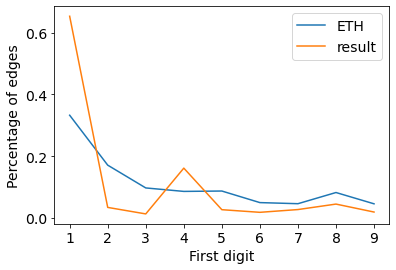

In [75]:
agg = []
for e in edgelist:
    if e[0] in res and e[1] in res:
        agg.append(e[2])

x = collections.Counter(agg)
cur_num_occ = np.array([x[k] for k in range(1,10)])/sum([x[k] for k in range(1,10)])
plt.plot([str(i) for i in range(1,10)], num_occ, label='ETH')
plt.plot([str(i) for i in range(1,10)], cur_num_occ, label='result')
plt.xlabel('First digit')
plt.ylabel('Percentage of edges')
plt.legend()
plt.show()

In [95]:
amounts = {}
for e in edgelist:
    if e[0] in res and e[1] in res:
        if e[0] not in amounts:
            amounts[e[0]] = {}
        if e[1] not in amounts[e[0]]:
            amounts[e[0]][e[1]] = []
        amounts[e[0]][e[1]].append(e[3])
# plt.hist(amounts)

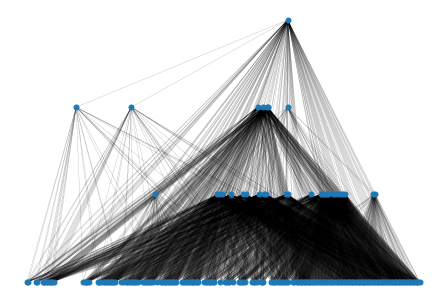

In [84]:
from networkx.drawing.nx_agraph import graphviz_layout
pos=graphviz_layout(G.subgraph(res), prog='dot')
nx.draw(G.subgraph(res), pos, with_labels=False,width=0.1, arrows=False, node_size=25)
            

In [19]:
f = open(dsd_output_prefix + '1','r')
line = f.readline()
res = []
while line:
    res.append(int(line.strip()))
    line = f.readline()
len(res)

341

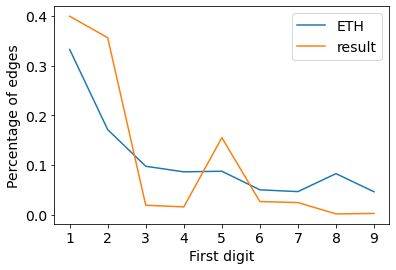

In [8]:
agg = []
for e in edgelist:
    if e[0] in res and e[1] in res:
        agg.append(e[2])

x = collections.Counter(agg)
cur_num_occ = np.array([x[k] for k in range(1,10)])/sum([x[k] for k in range(1,10)])
plt.plot([str(i) for i in range(1,10)], num_occ, label='ETH')
plt.plot([str(i) for i in range(1,10)], cur_num_occ, label='result')
plt.xlabel('First digit')
plt.ylabel('Percentage of edges')
plt.legend()
plt.show()

In [7]:
f = open(dsd_output_prefix + '2','r')
line = f.readline()
res = []
while line:
    res.append(int(line.strip()))
    line = f.readline()
len(res)

34

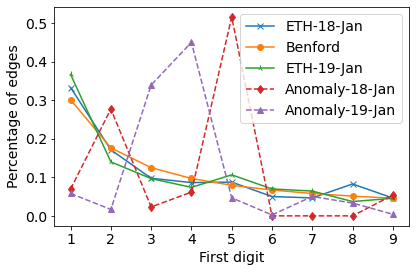

In [29]:
agg = []
for e in edgelist:
    if e[0] in res and e[1] in res:
        agg.append(e[2])

x = collections.Counter(agg)
cur_num_occ = np.array([x[k] for k in range(1,10)])/sum([x[k] for k in range(1,10)])
plt.plot([str(i) for i in range(1,10)], num_occ, label='ETH-18-Jan', marker='x')
plt.plot([str(i) for i in range(1,10)], benford, label='Benford', marker='o')
plt.plot([str(i) for i in range(1,10)], [0.36672383, 0.13989172, 0.09662453, 0.07386562, 0.10630361,
        0.06975926, 0.0642381 , 0.03712496, 0.04546838], label='ETH-19-Jan', marker='2')
plt.plot([str(i) for i in range(1,10)], cur_num_occ, '--', label='Anomaly-18-Jan', marker='d')

plt.plot([str(i) for i in range(1,10)], [0.05798817, 0.01656805, 0.33905325, 0.44970414, 0.04674556,
        0.00236686, 0.05029586, 0.03313609, 0.00414201], '--', label='Anomaly-19-Jan', marker='^')
plt.xlabel('First digit')
plt.ylabel('Percentage of edges')
plt.legend(loc='upper right', fontsize=14)
plt.tight_layout()
plt.savefig('eth_results/figs/token2018-19_dist.png')
plt.show()

In [9]:
amounts = {}
for e in edgelist:
    if e[0] in res and e[1] in res:
        if e[0] not in amounts:
            amounts[e[0]] = {}
        if e[1] not in amounts[e[0]]:
            amounts[e[0]][e[1]] = []
        amounts[e[0]][e[1]].append((e[3],e[4]))

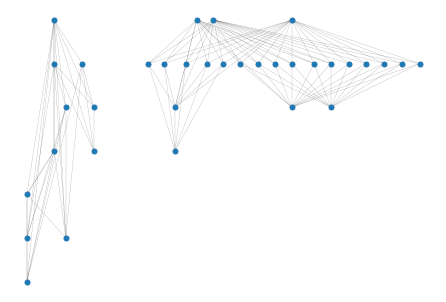

In [13]:
from networkx.drawing.nx_agraph import graphviz_layout
pos=graphviz_layout(G.subgraph(res), prog='dot')
nx.draw(G.subgraph(res), pos, with_labels=False,width=0.1, arrows=False, node_size=25)
            

In [18]:
top = [i for i in G.predecessors(935581)]
mid = set([i for i in res_g[788431]] + [i for i in res_g[1107511]] + [i for i in res_g[1438818]])
comp = set(top + list(mid) + list(bot))

<ipython-input-21-cd91116f1670>:4: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


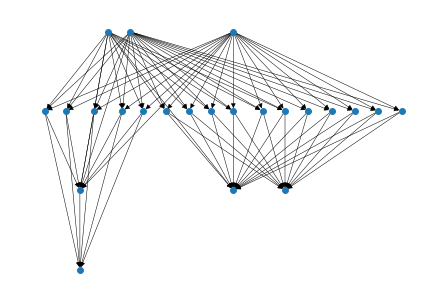

In [21]:
nex = G.subgraph(list(comp))
pos=graphviz_layout(nex, prog='dot')
nx.draw(nex, pos, with_labels=False,width=0.5, arrows=True, node_size=35)
plt.show()

In [6]:
f = open(dsd_output_prefix + '4','r')
line = f.readline()
res = []
while line:
    res.append(int(line.strip()))
    line = f.readline()
len(res)

117

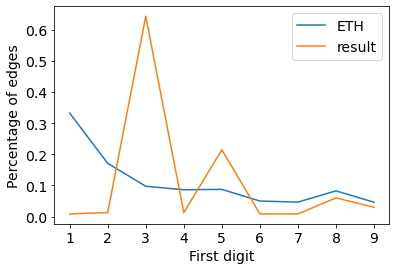

In [9]:
agg = []
for e in edgelist:
    if e[0] in res and e[1] in res:
        agg.append(e[2])

x = collections.Counter(agg)
cur_num_occ = np.array([x[k] for k in range(1,10)])/sum([x[k] for k in range(1,10)])
plt.plot([str(i) for i in range(1,10)], num_occ, label='ETH')
plt.plot([str(i) for i in range(1,10)], cur_num_occ, label='result')
plt.xlabel('First digit')
plt.ylabel('Percentage of edges')
plt.legend()
plt.show()